<a href="https://colab.research.google.com/github/akurniawan/ICS5110-final/blob/main/01-Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import math
import nltk
import numpy as np
import spacy
import seaborn as sns

from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from collections import Counter
from matplotlib import pyplot
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [2]:
review_df = pd.read_csv("yelp_review_sentiment_raw.csv", delimiter="\t")

In [3]:
review_df.head()

,review_id,stars,useful,date,text
0,xQY8N_XvtGbearJ5X4QryQ,2.0,5,2015-04-15 05:21:16,"As someone who has worked with many museums, I..."
1,UmFMZ8PyXZTY2QcwzsfQYA,1.0,1,2013-12-07 03:16:52,I am actually horrified this place is still in...
2,LG2ZaYiOgpr2DK_90pYjNw,5.0,1,2015-12-05 03:18:11,I love Deagan's. I do. I really do. The atmosp...
3,i6g_oA9Yf9Y31qt0wibXpw,1.0,0,2011-05-27 05:30:52,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g..."
4,6TdNDKywdbjoTkizeMce8A,4.0,0,2017-01-14 21:56:57,"Oh happy day, finally have a Canes near my cas..."


In [4]:
review_df.count()

review_id    8021122
stars        8021122
useful       8021122
date         8021122
text         8021120
dtype: int64

In [5]:
review_df["date"] = review_df["date"].map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [6]:
# Filter by year to only get a sort of fresh data to prevent language diversion
review_df = review_df[review_df["date"].dt.year >= 2016]
review_df.head()

,review_id,stars,useful,date,text
4,6TdNDKywdbjoTkizeMce8A,4.0,0,2017-01-14 21:56:57,"Oh happy day, finally have a Canes near my cas..."
7,lpFIJYpsvDxyph-kPzZ6aA,5.0,0,2017-07-18 18:31:54,"Awesome office and staff, very professional an..."
13,QCxPzh7cuxJrLd6A_UTbpw,5.0,0,2016-06-11 22:00:11,Everything that my husband and I tried today w...
15,mjbs5CL4eMu4o6_VtYhN3Q,1.0,0,2017-08-07 21:36:36,"If I could give less than one star, that would..."
17,Ne_2CSfcKIqXHmv_KC0uqg,4.0,3,2018-02-01 19:15:00,A close friend was in town and so instead of t...


In [7]:
review_df.count()

review_id    4845336
stars        4845336
useful       4845336
date         4845336
text         4845336
dtype: int64

In [8]:
def bin_fn(x):
    if 0 <= x < 1.25:
        return "bad"
    elif 1.25 <= x < 2.5:
        return "kind of bad"
    elif 2.5 <= x < 3.75:
        return "quite good"
    elif 3.75 <= x <= 5:
        return "good"

review_df["sentiment"] = review_df["stars"].apply(bin_fn)
review_df.head()

,review_id,stars,useful,date,text,sentiment
4,6TdNDKywdbjoTkizeMce8A,4.0,0,2017-01-14 21:56:57,"Oh happy day, finally have a Canes near my cas...",good
7,lpFIJYpsvDxyph-kPzZ6aA,5.0,0,2017-07-18 18:31:54,"Awesome office and staff, very professional an...",good
13,QCxPzh7cuxJrLd6A_UTbpw,5.0,0,2016-06-11 22:00:11,Everything that my husband and I tried today w...,good
15,mjbs5CL4eMu4o6_VtYhN3Q,1.0,0,2017-08-07 21:36:36,"If I could give less than one star, that would...",bad
17,Ne_2CSfcKIqXHmv_KC0uqg,4.0,3,2018-02-01 19:15:00,A close friend was in town and so instead of t...,good


<AxesSubplot:xlabel='sentiment', ylabel='Count'>

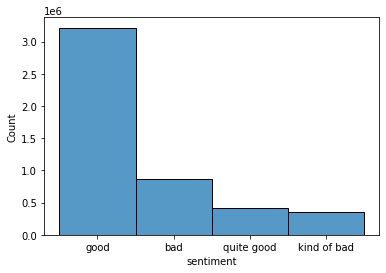

In [9]:
sns.histplot(review_df, x="sentiment")

In [10]:
total_data = 400000
good_df = review_df[review_df["sentiment"] == "good"].sample(n=total_data)
quite_good_df = review_df[review_df["sentiment"] == "quite good"]
kind_bad_df = review_df[review_df["sentiment"] == "kind of bad"]
bad_df = review_df[review_df["sentiment"] == "bad"].sample(n=total_data)

df = pd.concat([good_df, quite_good_df, kind_bad_df, bad_df])
df = df.sample(frac=1).reset_index(drop=True)
df.count()

review_id    1568963
stars        1568963
useful       1568963
date         1568963
text         1568963
sentiment    1568963
dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='Count'>

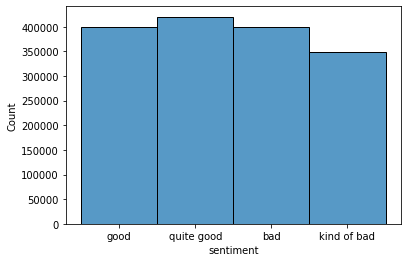

In [11]:
sns.histplot(df, x="sentiment")

In [3]:
# nlp = spacy.load("en", disable=["parser", "ner"])
porter = PorterStemmer()

def lemmatize(text):
    doc = nlp(text)
    lem = []
    for token in doc:
      lem.append(token.lemma_)
    return " ".join(lem)

def remove_special_characters(text):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text)
    return text

def remove_newline(text):
    pattern = r'(\n)+'
    text = re.sub(pattern, '', text)
    pattern = r'(\r)+'
    text = re.sub(pattern, '', text)
    pattern = r'(\r\n)+'
    text = re.sub(pattern, '', text)
    return text

def remove_multiple_whitespaces(text):
    pattern = r' {2,}'
    text = re.sub(pattern, ' ', text)
    pattern1 = r"\t+"
    text = re.sub(pattern1, ' ', text)
    return text

def preprocessing(text):
    text = str(text).strip().lower()
    # text = remove_special_characters(text)
    text = remove_newline(text)
    text = remove_multiple_whitespaces(text)
    # text = lemmatize(text)
    return text

# df["text"] = df["text"].apply(preprocessing)

In [14]:
df["text"] = df["text"].apply(lemmatize)

In [24]:
df["unigram"] = df["text"].apply(lambda x: x.split(" "))

In [25]:
df.head()

,review_id,stars,useful,date,text,sentiment,unigram
0,7hOiFRSsiNoi2-tY4vXobA,5.0,0,2016-04-10 23:38:49,grecian stuff potato pancake be incredible and...,good,"[grecian, stuff, potato, pancake, be, incredib..."
1,FT6d4_NDG4l1Y25RHP3Fqw,5.0,0,2019-06-02 21:37:59,the food be amazing portion be large and the c...,good,"[the, food, be, amazing, portion, be, large, a..."
2,4Eq3Y0mo3oQNuM-k6XCcYg,3.0,1,2019-01-21 16:19:38,ok to clear thing up -PRON- use to be a post o...,quite good,"[ok, to, clear, thing, up, -PRON-, use, to, be..."
3,KZOYk9xfOV1xlsO-nNv7IA,3.0,0,2019-05-15 17:46:33,first staff be very nice and plenty of -PRON- ...,quite good,"[first, staff, be, very, nice, and, plenty, of..."
4,YGuIyw6IypY3CRmVnyZZ-A,3.0,0,2018-02-08 18:10:21,great place for authentic laotian food -PRON- ...,quite good,"[great, place, for, authentic, laotian, food, ..."


In [19]:
df[["review_id", "stars", "date", "text", "sentiment"]].to_csv("yelp_review_sentiment.tsv", sep="\t")

In [2]:
df = pd.read_csv("yelp_review_sentiment.tsv", delimiter="\t")
df = df.dropna()

In [6]:
words = []
for idx, row in df.iterrows():
    words.extend(str(row["text"]).split(" "))
counter = Counter(words)
len(counter)

914338

[Text(0, 0, '-pron-'),
 Text(1, 0, 'be'),
 Text(2, 0, 'the'),
 Text(3, 0, 'and'),
 Text(4, 0, 'i'),
 Text(5, 0, 'to'),
 Text(6, 0, 'a'),
 Text(7, 0, 'not'),
 Text(8, 0, 'have'),
 Text(9, 0, 'of'),
 Text(10, 0, 'for'),
 Text(11, 0, 'in'),
 Text(12, 0, 'that'),
 Text(13, 0, 'do'),
 Text(14, 0, 'but'),
 Text(15, 0, 'this'),
 Text(16, 0, 'with'),
 Text(17, 0, 'on'),
 Text(18, 0, 'get'),
 Text(19, 0, 'at'),
 Text(20, 0, 'so'),
 Text(21, 0, 'go'),
 Text(22, 0, 'good'),
 Text(23, 0, 'food'),
 Text(24, 0, 'place'),
 Text(25, 0, 'there'),
 Text(26, 0, 'time'),
 Text(27, 0, 'order'),
 Text(28, 0, 'as'),
 Text(29, 0, 'come'),
 Text(30, 0, 'would'),
 Text(31, 0, 'out'),
 Text(32, 0, 'if'),
 Text(33, 0, 'very'),
 Text(34, 0, 'service'),
 Text(35, 0, 'like'),
 Text(36, 0, 'just'),
 Text(37, 0, 'all'),
 Text(38, 0, 'one'),
 Text(39, 0, 'when'),
 Text(40, 0, 'here'),
 Text(41, 0, 'say'),
 Text(42, 0, 'back'),
 Text(43, 0, 'will'),
 Text(44, 0, 'up'),
 Text(45, 0, 'no'),
 Text(46, 0, 'or'),
 Text(47, 0

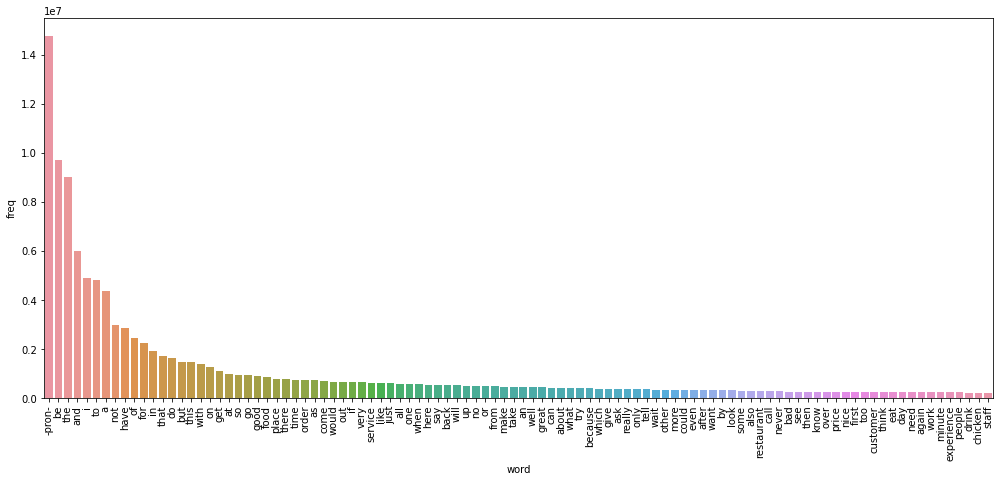

In [7]:
a4_dims = (17, 7)
fig, ax = pyplot.subplots(figsize=a4_dims)
g = sns.barplot(data=pd.DataFrame(counter.most_common(100), columns=["word", "freq"]), x="word", y="freq", ax=ax)
g.set_xticklabels(labels=g.get_xticklabels(), rotation=90)

In [5]:
en_stopwords = stopwords.words('english') + ["-pron-"]
words = []
for idx, row in df.iterrows():
    words.extend([word for word in str(row["text"]).split(" ") if word not in en_stopwords])
counter = Counter(words)
len(counter)

[Text(0, 0, 'get'),
 Text(1, 0, 'go'),
 Text(2, 0, 'good'),
 Text(3, 0, 'food'),
 Text(4, 0, 'place'),
 Text(5, 0, 'time'),
 Text(6, 0, 'order'),
 Text(7, 0, 'come'),
 Text(8, 0, 'would'),
 Text(9, 0, 'service'),
 Text(10, 0, 'like'),
 Text(11, 0, 'one'),
 Text(12, 0, 'say'),
 Text(13, 0, 'back'),
 Text(14, 0, 'make'),
 Text(15, 0, 'take'),
 Text(16, 0, 'well'),
 Text(17, 0, 'great'),
 Text(18, 0, 'try'),
 Text(19, 0, 'give'),
 Text(20, 0, 'ask'),
 Text(21, 0, 'really'),
 Text(22, 0, 'tell'),
 Text(23, 0, 'wait'),
 Text(24, 0, 'could'),
 Text(25, 0, 'even'),
 Text(26, 0, 'want'),
 Text(27, 0, 'look'),
 Text(28, 0, 'also'),
 Text(29, 0, 'restaurant'),
 Text(30, 0, 'call'),
 Text(31, 0, 'never'),
 Text(32, 0, 'bad'),
 Text(33, 0, 'see'),
 Text(34, 0, 'know'),
 Text(35, 0, 'price'),
 Text(36, 0, 'nice'),
 Text(37, 0, 'first'),
 Text(38, 0, 'customer'),
 Text(39, 0, 'think'),
 Text(40, 0, 'eat'),
 Text(41, 0, 'day'),
 Text(42, 0, 'need'),
 Text(43, 0, 'work'),
 Text(44, 0, 'minute'),
 Text

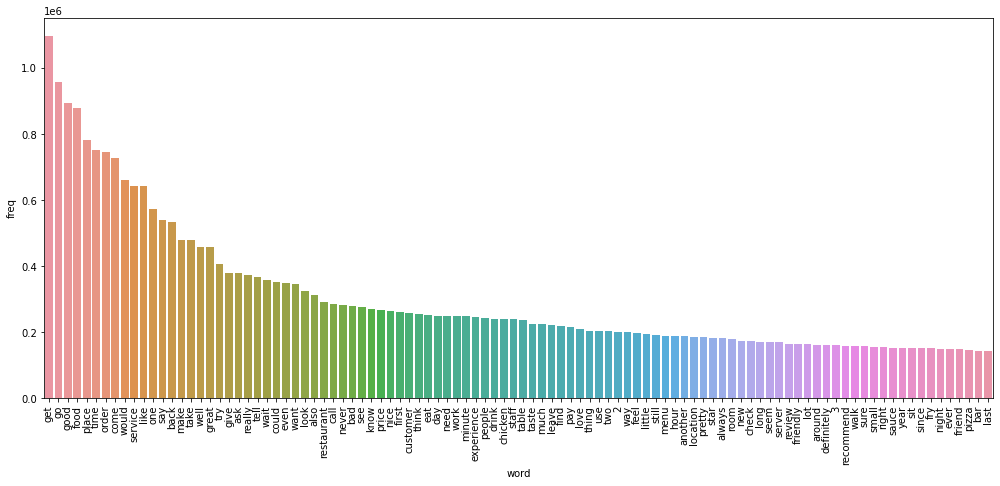

In [61]:
a4_dims = (17, 7)
fig, ax = pyplot.subplots(figsize=a4_dims)
g = sns.barplot(data=pd.DataFrame(counter.most_common(100), columns=["word", "freq"]), x="word", y="freq", ax=ax)
g.set_xticklabels(labels=g.get_xticklabels(), rotation=90)

# Machine Learning Model Experiments with 4 Classes

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

In [6]:
en_stopwords = stopwords.words('english') + ["-pron-", "pron"]

cnt_vec = CountVectorizer(ngram_range=(1, 3), min_df=10, stop_words=en_stopwords)
tfidf_vec = TfidfVectorizer(ngram_range=(1, 3), min_df=10, stop_words=en_stopwords)
label_enc = LabelEncoder()
label_bin = LabelBinarizer()
normalizer = Normalizer()

In [7]:
sample_data = df.sample(220000)
train, test = train_test_split(sample_data, test_size=0.1, shuffle=True)

cnt_vec.fit(train["text"])
tfidf_vec.fit(train["text"])
label_enc.fit(df["sentiment"].unique())

/Users/akurniawan/opt/miniconda3/envs/ics5110/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['pron'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


((198000, 230884), (198000, 230884))

In [56]:
logistic = LogisticRegression(random_state=42, max_iter=100000)
mnb = MultinomialNB()
rf = RandomForestClassifier(n_jobs=-1, random_state=42)


combinations = [
    (logistic, cnt_vec, None),
    (logistic, tfidf_vec, None),
    (logistic, cnt_vec, normalizer),
    (logistic, tfidf_vec, normalizer),
    (mnb, cnt_vec, None),
    (rf, cnt_vec, None),
    (rf, tfidf_vec, None),
    (rf, cnt_vec, normalizer),
    (rf, tfidf_vec, normalizer),
]

res = {}
for comb in combinations:
    model = comb[0]
    model_name = type(model).__name__
    
    print("Prepare data to train..")
    featurizer = comb[1]
    featurizer_name = type(featurizer).__name__
    X_train = featurizer.transform(train["text"])
    y_train = label_enc.transform(train["sentiment"])
    X_test = featurizer.transform(test["text"])
    y_test = label_enc.transform(test["sentiment"])
    
    normalizer_name = "None"
    if comb[2]:
        normalizer = comb[2]
        normalizer_name = type(normalizer).__name__
        X_train = normalizer.fit_transform(X_train)
        X_test = normalizer.transform(X_test)
        
    metadata = model_name + "-" + featurizer_name + "-" + normalizer_name
    
    print("Cross-validate {}".format(metadata))
    score = cross_validate(model, X_train, y_train,
                           scoring=["f1_micro", "precision_micro", "recall_micro"],
                           cv=5, n_jobs=-1, return_train_score=True)
    res[metadata] = score
    print(metadata, score)

Prepare data to train..
Cross-validate LogisticRegression-CountVectorizer-None
LogisticRegression-CountVectorizer-None {'fit_time': array([2447.32094288, 2435.27109909, 2447.24594998, 2434.61051106,
       2369.61255503]), 'score_time': array([0.204386  , 0.3321619 , 0.20633531, 0.47214317, 0.40806508]), 'test_f1_micro': array([0.65      , 0.64941919, 0.65234848, 0.65017677, 0.64891414]), 'train_f1_micro': array([0.99838384, 0.99828283, 0.99840909, 0.99835859, 0.99834596]), 'test_precision_micro': array([0.65      , 0.64941919, 0.65234848, 0.65017677, 0.64891414]), 'train_precision_micro': array([0.99838384, 0.99828283, 0.99840909, 0.99835859, 0.99834596]), 'test_recall_micro': array([0.65      , 0.64941919, 0.65234848, 0.65017677, 0.64891414]), 'train_recall_micro': array([0.99838384, 0.99828283, 0.99840909, 0.99835859, 0.99834596])}
Prepare data to train..
Cross-validate LogisticRegression-TfidfVectorizer-None
LogisticRegression-TfidfVectorizer-None {'fit_time': array([423.11136198, 

## Hyperparameter tuning

In [63]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [69]:
hyperparams = dict(C=[0.1, 0.25, 0.5, 0.75, 1])
tuning_logistic = RandomizedSearchCV(LogisticRegression(random_state=42, max_iter=100000), hyperparams, random_state=0, n_jobs=-1, verbose=2)
tuning_logistic.fit(X_cnt_norm, label_enc.transform(train["sentiment"]))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/akurniawan/opt/miniconda3/envs/ics5110/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:  3.3min remaining:   17.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  3.5min finished


RandomizedSearchCV(estimator=LogisticRegression(max_iter=100000,
                                                random_state=42),
                   n_jobs=-1,
                   param_distributions={'C': [0.1, 0.25, 0.5, 0.75, 1]},
                   random_state=0, verbose=2)

In [71]:
pred = tuning_logistic.predict(normalizer.transform(cnt_vec.transform(test["text"])))
print(classification_report(label_enc.transform(test["sentiment"]), pred, target_names=label_enc.classes_))

              precision    recall  f1-score   support

         bad       0.68      0.79      0.73      2589
        good       0.80      0.82      0.81      2534
 kind of bad       0.51      0.39      0.44      2249
  quite good       0.58      0.60      0.59      2628

    accuracy                           0.66     10000
   macro avg       0.65      0.65      0.64     10000
weighted avg       0.65      0.66      0.65     10000



In [72]:
tuning_logistic.best_score_

0.65886